# QAOA Implementation for the weighted MaxCut problem


Importing Dependencies

In [1]:
from typing import List, Tuple

#import math tools
import numpy as np
import random
from scipy.optimize import minimize

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter


# importing Qiskit

from qiskit import*


#As I have got an runtime error that qiskit-Aer is not properly installed locally, hence to solve the probelm I used BasicAer
#in the backend

c:\users\sakib\qc_sakib\lib\site-packages\qiskit\__init__.py:64: RuntimeWarning: Could not import the Aer provider from the qiskit-aer package. Install qiskit-aer or check your installation.
  RuntimeWarning)


# The Weighted MaxCut Problem
Given a set of vertices and weighted edges connecting some of the vertices, we are interested in separating the vertices into two sets such that the sum of the weights of the edges between the sets is maximized.

# Intro to QAOA

The goal of the QAOA is to  prepare low-energy states of a cost Hamiltonian ${H}_C$, which is usually a Hamiltonian diagonal in the computational basis. To achieve this, we will begin in an eigenstate of a mixer Hamiltonian ${H}_M$, which does not commute with the cost Hamiltonian; $[{H}_C,{H}_M] \neq 0$. Applied onto this initial state is a sequence of exponentials of the form
$$
   {U}(\vec{\theta}) = \prod_{j=1}^{P}e^{-i\theta^{(j)}_m{H}_M}e^{-i\theta^{(j)}_{c} {H}_C}, 
$$
where $\vec{\theta} = \{\vec{\theta}_m,\vec{\theta}_c\}$ are variational parameters to be optimized. The objective function for this optimization is simply extract the expectation of the cost Hamiltonian after applying $\hat{U}(\theta)$ to the initial state. This sequence of exponentials is the ansatz. The cost Hamiltonian represents our problem at hand. The mixer Hamiltonian is our initial state.

We have to perform the following tasks in order to implement the QAOA:



1.   Create a quantum circuit alternating $U (\vec{\theta}_m,{H}_M)$ and $U(\vec{\theta}_m,{H}_C)$ operations as many times as desired. 
2.   Find the optimal value of the variational parameters in our circuit.
3.   Measure the output of our circuit.

# Weighted Graph Generation

In [2]:
#Networkx Graph object for the construction of the Graph

class Graph:
    """
    This is a class defining the Graph that will be used by Networkx
    for the purpose of implementation and demonstration of the 
    QAOA algorithm

    Attributes
    ----------
    edges_set            :   (list) Contains the list of connecting edges in the Graph
                         that is to be constructed
    node_set             :   (list) Contains the list of nodes existing in the Graph 
                         that is to be constructed, extracted from the edges_set
    """
    def __init__(self, edges_set):                                                  
        self.edges_set = edges_set                                                  
        self.node_set = []                                                          
        for i in edges_set:                                                         
            if (i.start_node not in self.node_set):
                self.node_set.append(i.start_node)                                  
            if (i.end_node not in self.node_set):
                self.node_set.append(i.end_node)   
                

        


In [3]:
#Networkx Edge object for the construction of the Graph

class Edge:
    """
    This is a class defining the edges of the Graph that will be used by 
    Networkx for the purpose of implementation and demonstration of the 
    QAOA algorithm

    Attributes
    ----------
    start_node           :   (int) This is a variable containing the starting node
                             of a connecting edge in the Graph
    end_node             :   (int) This is a variable containing the ending node of
                             a connecting edge in the Graph
    """
    def __init__(self, start_node, end_node):
        self.start_node = start_node
        self.end_node = end_node

In [4]:
#The edges set as defined in the problem statement (blog post)

edges_set = [Edge(0, 1), Edge(1, 2), Edge(2, 3), Edge(3, 0), Edge(2, 0), Edge(1, 3), Edge(0, 4), Edge(1, 4), Edge(2, 4), Edge(3, 4), Edge(4, 5), Edge(5, 0), Edge(2, 6), Edge(6, 3)]


In [5]:
#Defining seed in random so that the results are reproducible
np.random.seed(seed=1)

In [6]:
#Assigning weights to the edges and appending to a list

edges_weight_set = []
for edges in edges_set:
    # Generate a randomly weighted edge between them. Here the weighting
    # is a random 2 decimal floating point between 0 and 5.
    edges_weight_set.append(np.random.randint(0, 500) / 100)

#print(edges_weight_set)

In [7]:
#Invoking the Graph object for building the Graph

working_graph = nx.Graph()
for z1,z2 in zip(edges_set, edges_weight_set):                                        
            working_graph.add_edge(z1.start_node, z1.end_node,weight=z2)

{(0, 1): Text(0.11693869108215768, 0.00673399293242799, '0.37'),
 (0, 3): Text(-0.03526351306018763, -0.0707201587013108, '0.72'),
 (0, 2): Text(-0.20450297235499265, -0.03920595479300379, '2.55'),
 (0, 4): Text(-0.04001631495865149, -0.28103747949490543, '2.03'),
 (0, 5): Text(-0.11246804741960553, -0.6743797878431281, '1.29'),
 (1, 2): Text(0.1601448872164265, 0.3162876138256806, '2.35'),
 (1, 3): Text(0.32938434651123155, 0.28477340991737354, '3.93'),
 (1, 4): Text(0.32463154461276766, 0.07445608912377893, '1.33'),
 (2, 3): Text(0.007942683074081205, 0.2388334621919418, '3.96'),
 (2, 4): Text(0.0031898811756173456, 0.028516141398347156, '3.35'),
 (2, 6): Text(-0.3007545683776055, 0.4962640695775322, '4.6'),
 (3, 4): Text(0.17242934047042238, -0.002998062509959862, '4.48'),
 (3, 6): Text(-0.13151510908280045, 0.46474986566922516, '0.71'),
 (4, 5): Text(0.09522480611100448, -0.6066576916517772, '1.44')}

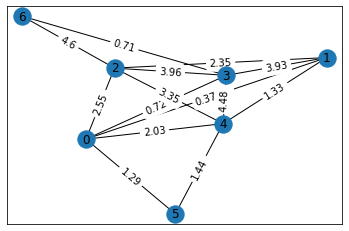

In [8]:
#Visualising the Graph created

pos=nx.spring_layout(working_graph)                                                               
nx.draw_networkx(working_graph,pos)                                                               
labels = nx.get_edge_attributes(working_graph,'weight')                                           
nx.draw_networkx_edge_labels(working_graph,pos,edge_labels=labels)   

# Creating Initial Superposition State

In [9]:
num = len(edges_set)   #Number of nodes. Each node is assigned a qubit.
depth = 1 #Number of layers

def initialization(qc):    #creating all the possible input candidates
    for i in qc.qubits:
        qc.h(i)
    return qc

# Creating the cost Hamiltonian

As long as the QAOA is polynomial time bounded, so we have to be careful to find the optimal solution in the bounded time, hence approximation ration and steps size have to chosen carefully as long as the increment of the node size.  In the intro, I mentioned that QAOA has an unitary operators, actually there are 2 unitary operators to find the optimal solution. To find the solutation we have to use the define the hamiltonian as a cost function of 2 pauli Z operators. 

$$H=\frac{w_{ij}}{2}(1- Z_{i}Z_{j})$$

As we are working on weighted graph so the weighted value is added to the cost functions. And this operators $U_{C}=(H_{C},\theta_{c})$ and $U_{M}=(H_{M},\theta_{m})$ will evolve with the state of hamiltonian $H_{C}$ and $H_{M}$ for $\theta_{c}$ and $\theta_{m}$ time respectively. 

In [10]:
def unitary_layer(qc,param1):
    for i in range(0,len(edges_set)):
        qc.u(0,0,param1,qc.qubits[edges_set[i].start_node])   
        qc.u(0,0,param1,qc.qubits[edges_set[i].end_node])
        qc.barrier()
    return qc

# Creating the mixer Hamiltonian

In [11]:
def mixture_layer(qc,param2):
    for i in range(0,num):
        qc.rx(param2,qc.qubits[i])
    qc.barrier()
    return qc

# Creqating the ansatz circuit

There are two ways to generate ansatz: 1. Physcially-inpired circuit 2. Hardware efficient. Second one is mostly is used for the transmon qubit or topological based circuit. To develop physically-inspired algorithm one has to look into the circuit structure, then develop the circuit accordingly. In this problem statement the physically-inspired algo is used.

In [15]:
params = [float(random.randint(-314, 314))/float(100) for i in range(0, 2*depth)]
def create_circuit(params):   
    q = QuantumRegister(num)
    c = ClassicalRegister(num)
    qc = QuantumCircuit(q,c)
    qc = initialization(qc)
    for i in range(0,int(len(params)/2)):
        param1 = params[i]
        param2 = params[i+1]
        qc = unitary_layer(qc,param1)
        qc = mixture_layer(qc,param2)
    qc.measure(qc.qubits,c)
    

    
    simulator = BasicAer.get_backend('qasm_simulator')
    result = execute(qc, simulator).result()
    counts = result.get_counts(qc)
    results = counts.keys()
    new_res=[]
    for key in results:
        hold=[]
        for i in range(0,len(key)):
            hold.append(int(key[i]))
        for i in range(0,counts[key]):
            new_res.append(hold)
    
    return qc,counts,new_res  #new_res an integer matrix of shape(1024,num) containing measured output for each node 1024 times.
 

# Generate adjacency matrix


In [16]:
A = np.zeros([num,num],dtype=int)  #weight matrix with rows indicating start node and colomns indicating end node of each edge.
for i in range(0,len(edges_set)):
    A[edges_set[i].start_node][edges_set[i].end_node] = i+1
print(A)

[[ 0  1  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  6  8  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  3  9  0 13  0  0  0  0  0  0  0]
 [ 4  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0]
 [12  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


# Define the cost function

In [17]:
def cost_function(params):#maps measurement outputs to labels 1,-1 and claculates the cost
    qc,counts,result = create_circuit(params)
    total_cost = 0
    for i in range(0, len(result)):
        for j in edges_set:
            total_cost += 0.5*(A[j.start_node][j.end_node])*( ( (1 - 2*result[i][j.start_node]) * (1 - 2*result[i][j.end_node]) ) - 1)
    total_cost = float(total_cost)/1024
    return total_cost

cost = cost_function(params)
print(cost)

-52.4951171875


In [18]:
out = minimize(cost_function, x0=params, method="COBYLA", options={'maxiter':100})
print(out)

     fun: -52.955078125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([-3.11180355, -2.81089827])


In [19]:
#obtaining results for optimal parameters
circuit,counts,result = create_circuit(out['x'])

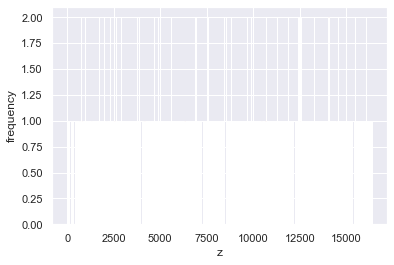

In [24]:

#Plotting graph
x=[]
y=[]
for key in counts.keys():
    number=0
    for i in range(0,len(key)):
        number = number + (2**i)*int(key[i])
    x.append(number)
    y.append(counts[key])
import seaborn as sns
sns.set()
plt.bar(x,y,color='r')
plt.xlabel("z")
plt.ylabel("frequency")
plt.show()